In [677]:

# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
#Tensorflow libs
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
import cv2

In [678]:
# Defining training and testing directories
base_dir = './fruits/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [679]:
# Checking if the training directory exists
if not os.path.exists(base_dir):
    raise Exception(f"Base directory {base_dir} does not exist.")
elif not os.path.exists(train_dir):
    raise Exception(f"Training directory {train_dir} does not exist.")
elif not os.path.exists(test_dir):
    raise Exception(f"Testing directory {test_dir} does not exist.")
else:
    print("All directories exist.")

All directories exist.


In [680]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU found, using CPU.")

No GPU found, using CPU.


In [681]:
# Iterating through subdirectories of the training directory to check for corrupted images
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    # Iterating files in the subdirectory
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)
        # Checking if the file is an image
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            print(f"Skipping {file_path} due to invalid file extension")
            continue
        # Checking if the image is corrupted or not
        try:
            with tf.keras.preprocessing.image.load_img(file_path) as img:
                img.verify() 
        except (IOError, SyntaxError) as e:
            print(f"Deleting corrupted file {file_path}: {e}")
            os.remove(file_path)

# Iterating through subdirectories in the training directory
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    # 
    num_images = len([name for name in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, name))])
    print(f"Number of images in {subdir}: {num_images}")

Number of images in apple: 1312
Number of images in avocado: 1312
Number of images in banana: 1312
Number of images in blueberry: 1312
Number of images in cantaloupe: 1312
Number of images in cherry: 1312
Number of images in dragonfruit: 1301
Number of images in emblic: 1304
Number of images in grape: 1312
Number of images in guava: 1312
Number of images in jackfruit: 1300
Number of images in kiwi: 1311
Number of images in lychee: 1312
Number of images in mango: 1312
Number of images in orange: 1312
Number of images in papaya: 1312
Number of images in pear: 1312
Number of images in pineapple: 1312
Number of images in pomegranate: 1312
Number of images in raspberry: 1312
Number of images in strawberry: 1312
Number of images in watermelon: 1312


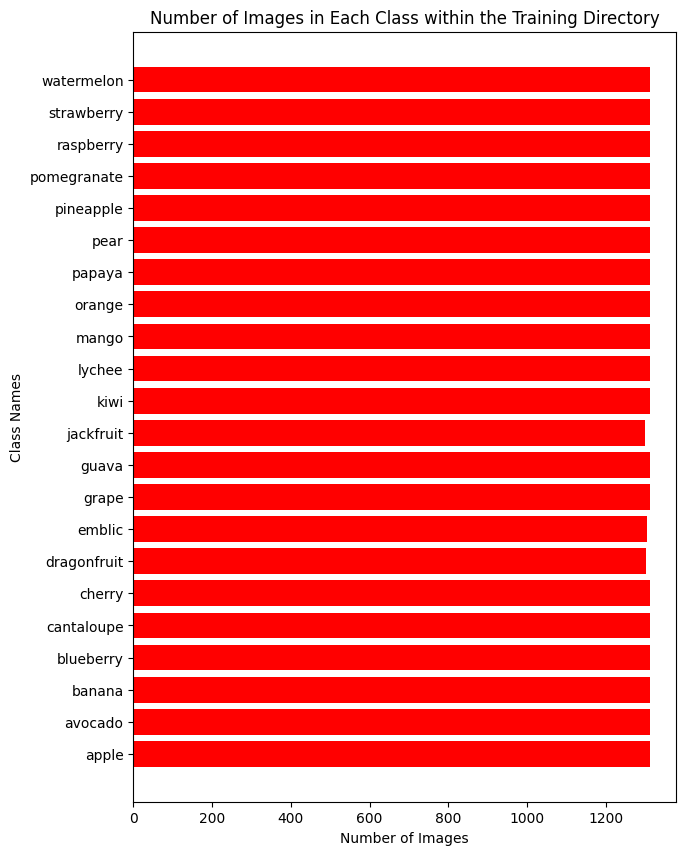

In [682]:
# Count the number of images in each class within the training directory
class_counts = {}
for subdir in os.listdir(train_dir):
	subdir_path = os.path.join(train_dir, subdir)
	if os.path.isdir(subdir_path):
		num_images = len([name for name in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, name))])
		class_counts[subdir] = num_images

# Extract class names and their corresponding image counts
class_names = sorted(list(class_counts.keys()))
image_counts = list(class_counts.values())

# Create a bar chart
plt.figure(figsize=(7, 10))
plt.barh(class_names, image_counts, color='red')
plt.xlabel('Number of Images')
plt.ylabel('Class Names')
plt.title('Number of Images in Each Class within the Training Directory')
plt.show()

In [683]:
BATCH_SIZE = 32
IMAGE_SIZE = 100
CHANNELS = 3

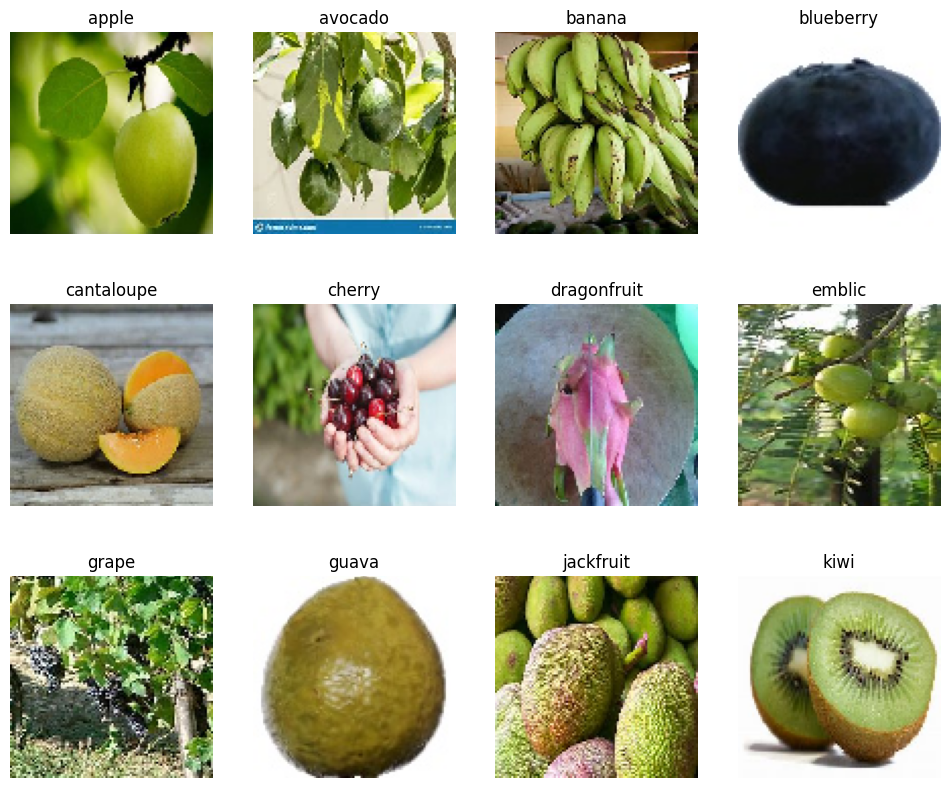

In [684]:
plt.figure(figsize=(12, 10))
classes = os.listdir(train_dir)[:12]  # Limit to 12 classes
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    file_name = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][0]
    img_path = os.path.join(class_dir, file_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [685]:
# Applying data augmentation to the training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomZoom(0.25),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomFlip(mode='vertical'),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomShear(0.2)
])

In [686]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.25,
    rotation_range=25,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)


train_dataset = train_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 28832 images belonging to 22 classes.


In [687]:
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Specify the validation split
)

val_dataset = val_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Specify the subset as validation
)

Found 5758 images belonging to 22 classes.


In [688]:
# Load existing model
# If model is not available, create a new model
if os.path.exists('fruits_classification.keras'):
    model = tf.keras.models.load_model('fruits_classification.keras')
    print("Model loaded.")
else:
    # Model architecture 
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

Model loaded.


In [689]:
model.summary()

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 22)             │        11,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,975,940 (76.20 MB)

 Trainable params: 6,658,646 (25.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,317,294 (50.80 MB)

In [690]:
# Calculate steps per epoch and validation steps
steps_per_epoch = 200
# validation_steps = 50

# steps_per_epoch = train_dataset.samples // train_dataset.batch_size
validation_steps = val_dataset.samples // val_dataset.batch_size

steps_per_epoch, validation_steps

(200, 179)

In [691]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('fruits_classification.keras', save_best_only=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduceLearningRate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

In [692]:
# Compiling the model using the Adam optimizer and categorical cross entropy-loss function
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.Precision()])

# Training the model using the CallbackAcc object and storing the history of the model
history = model.fit(
    train_dataset, # Train the model on the augmented training images
    steps_per_epoch=steps_per_epoch,   # Number of steps (batches) to yield from the generator at each epoch
    validation_steps=validation_steps,   # Number of steps (batches) to yield from the generator at each epoch
    epochs=20,    # Number of epochs to train the model
    validation_data=val_dataset,    # Validate the model on the augmented validation images
    verbose=1,    # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
    callbacks=[checkpoint, earlyStopping, reduceLearningRate]    # Callback function to stop training if accuracy is greater than or equal to 99%
)


e:\pythonproject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 347ms/step - accuracy: 0.5370 - loss: 1.8853 - precision_41: 0.8742 - val_accuracy: 0.5964 - val_loss: 1.7754 - val_precision_41: 0.9235 - learning_rate: 1.0000e-04
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 349ms/step - accuracy: 0.5444 - loss: 1.8634 - precision_41: 0.8670 - val_accuracy: 0.6025 - val_loss: 1.7629 - val_precision_41: 0.9288 - learning_rate: 1.0000e-04
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 344ms/step - accuracy: 0.5410 - loss: 1.8801 - precision_41: 0.8738 - val_accuracy: 0.6035 - val_loss: 1.7540 - val_precision_41: 0.9192 - learning_rate: 1.0000e-04
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 345ms/step - accuracy: 0.5511 - loss: 1.8682 - precision_41: 0.8650 - val_accuracy: 0.6138 - val_loss: 1.7512 - val_precision_41: 0.9276 - learning_rate: 1.0000e-04
Epoch 5/20
101/200 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.5534 - loss: 1.8559 - precision_41: 0.8585

e:\pythonproject\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - accuracy: 0.5582 - loss: 1.8402 - precision_41: 0.8623 - val_accuracy: 0.6109 - val_loss: 1.7316 - val_precision_41: 0.9391 - learning_rate: 1.0000e-04
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 340ms/step - accuracy: 0.5761 - loss: 1.8020 - precision_41: 0.8780 - val_accuracy: 0.6281 - val_loss: 1.6985 - val_precision_41: 0.9307 - learning_rate: 1.0000e-04
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 339ms/step - accuracy: 0.5674 - loss: 1.8095 - precision_41: 0.8719 - val_accuracy: 0.6219 - val_loss: 1.7000 - val_precision_41: 0.9296 - learning_rate: 1.0000e-04
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 341ms/step - accuracy: 0.5833 - loss: 1.7855 - precision_41: 0.8822 - val_accuracy: 0.6260 - val_loss: 1.6862 - val_precision_41: 0.9327 - learning_rate: 1.0000e-04
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 339ms/step - accuracy: 0.5816 - loss: 1.7810 - precision_41: 0.8907 - val_accuracy: 0.6196 - val_loss: 1.6959 - val_precision_41: 0

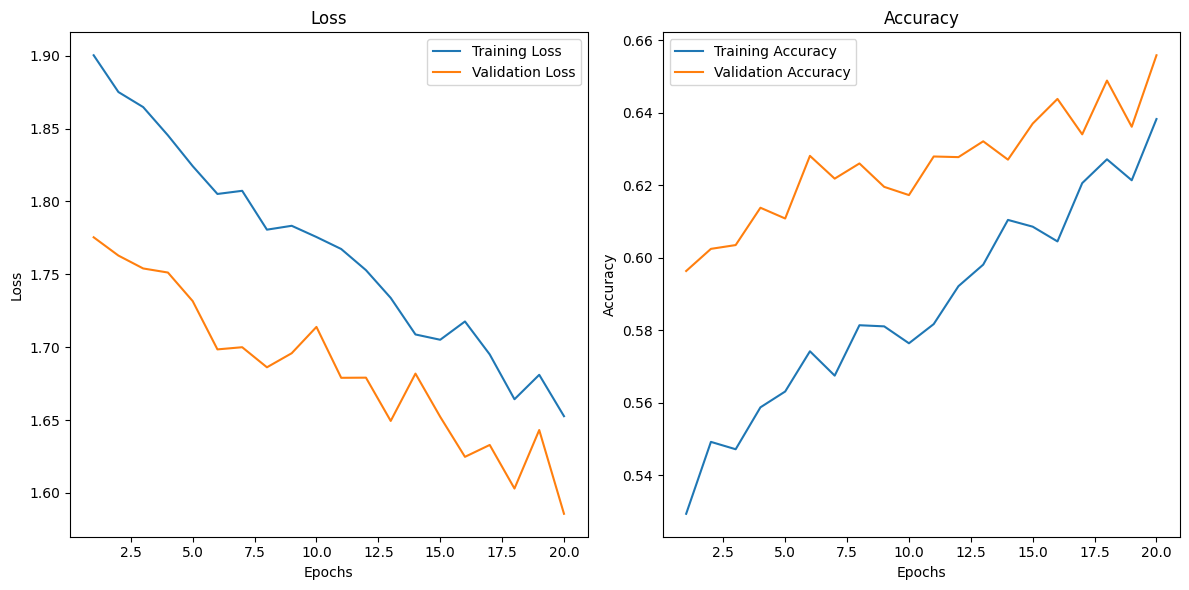

In [ ]:
# Plotting loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [694]:
def load_test_images_structured(directory, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    images = []  # Initialize an empty list to store images
    labels = []  # Initialize an empty list to store labels
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]  # Get all subdirectories in the directory
    for class_dir in class_dirs:  # Iterate over each class directory
        class_path = os.path.join(directory, class_dir)  # Get the full path of the class directory
        for filename in os.listdir(class_path):  # Iterate over each file in the class directory
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check if the file is an image
                img_path = os.path.join(class_path, filename)  # Get the full path of the image file
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)  # Load the image with the specified target size
                img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert the image to an array
                img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch axis
                images.append(img_array)  # Append the image array to the images list
                labels.append(class_dir)  # Append the class label to the labels list
    return np.vstack(images), labels  # Return the stacked images and labels

342/342 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step
Class Indices from Training: ['apple', 'avocado', 'banana', 'blueberry', 'cantaloupe', 'cherry', 'dragonfruit', 'emblic', 'grape', 'guava', 'jackfruit', 'kiwi', 'lychee', 'mango', 'orange', 'papaya', 'pear', 'pineapple', 'pomegranate', 'raspberry', 'strawberry', 'watermelon']
              precision    recall  f1-score   support

           0       0.77      0.46      0.58      1056
           1       0.85      0.66      0.75       494
           2       0.71      0.68      0.70       625
           3       0.77      0.90      0.83       354
           4       0.79      0.83      0.81       521
           5       0.64      0.64      0.64       820
           6       0.62      0.54      0.58       207
           7       0.31      0.53      0.39       204
           8       0.86      0.58      0.69       908
           9       0.64      0.55      0.60       370
          10       0.42      0.64      0.51       206
          11       0.71      0.

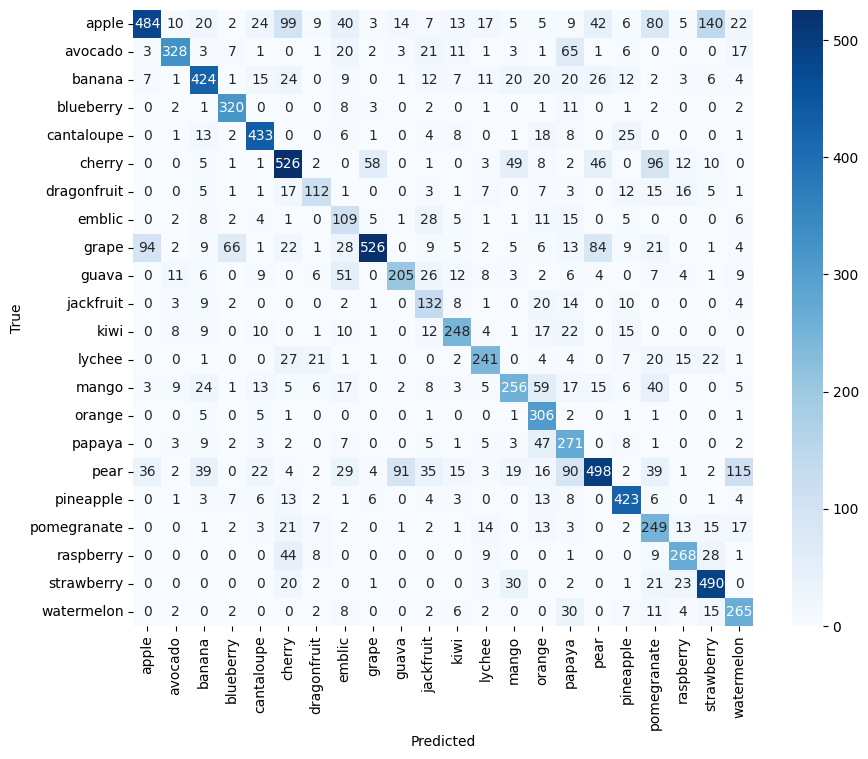

In [695]:
# Load and preprocess test images
test_images, test_labels = load_test_images_structured(test_dir)

# Normalize the test images
test_images = test_images / 255.0

# Predict the classes of the test images
predictions = model.predict(test_images)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Print the class indices from training
print("Class Indices from Training:", class_names)

# Adjust test labels to lowercase
adjusted_test_labels = [label.lower() for label in test_labels]

# Create a label map from class names to indices
label_map = {name.lower(): idx for idx, name in enumerate(class_names)}

# Map true class labels to their corresponding indices
true_classes = [label_map[label] for label in adjusted_test_labels]

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=list(label_map.values()))

# Print the classification report
print(classification_report(true_classes, predicted_classes, labels=list(label_map.values()), zero_division=0))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [696]:
# Evaluate the model
results = model.evaluate(test_images, tf.keras.utils.to_categorical(true_classes), verbose=1)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

342/342 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.5916 - loss: 1.8936 - precision_41: 0.8015
Test Loss: 1.6206893920898438
Test Accuracy: 0.6511670351028442


In [697]:
# Prediction function
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale
    
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

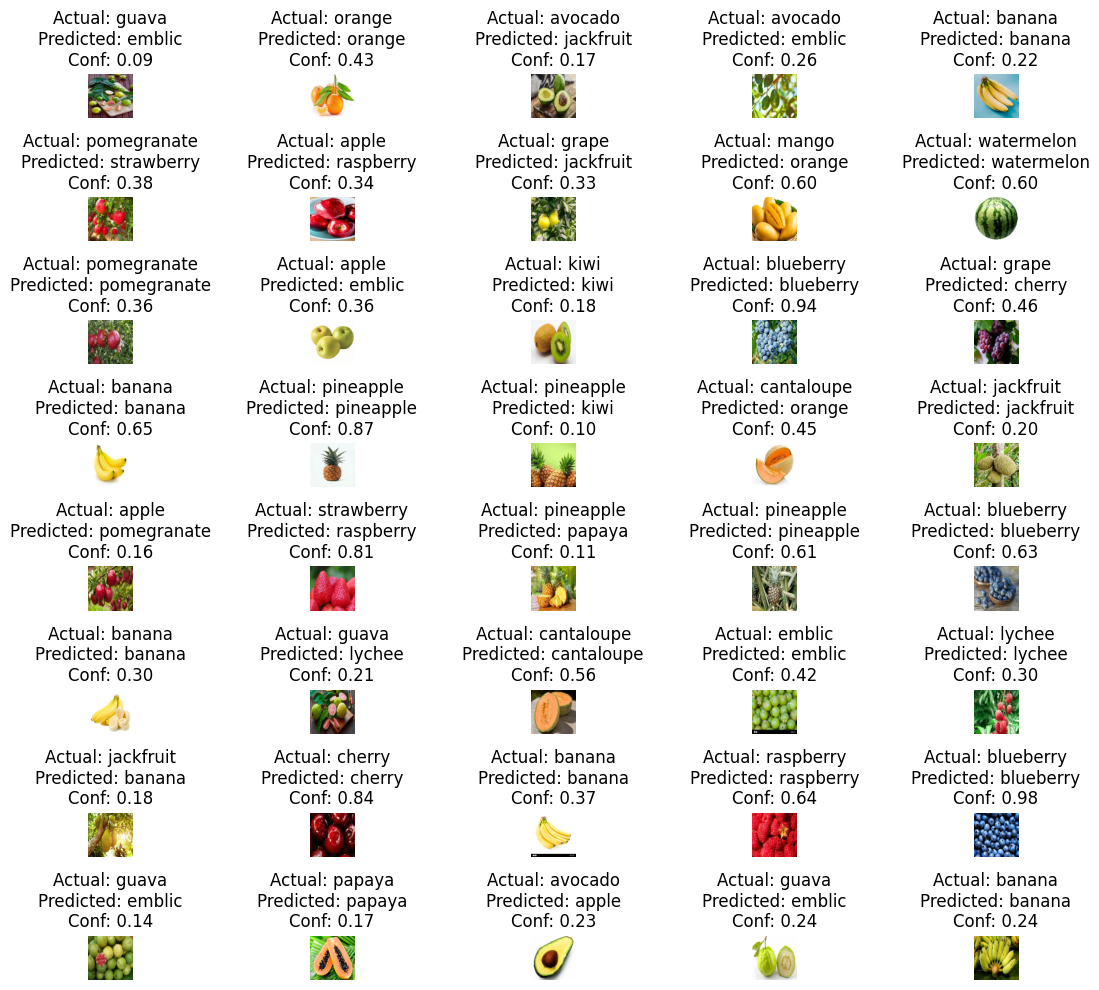

In [698]:
#get random 10 images from dir
random_images = random.sample(os.listdir('./fruits/predict/'), 40)
actual_labels = [img.split('_')[0] for img in random_images]
plt.figure(figsize=(12, 10))
for i, img in enumerate(random_images):
    img_path = os.path.join('./fruits/predict/', img)
    predicted_class, confidence = predict_image(img_path)
    plt.subplot(8, 5, i + 1)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    plt.imshow(img)
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_class}\nConf: {confidence:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# # Use webcam to predict in real-time
# cap = cv2.VideoCapture(0)
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         continue
    
#     # Save the frame as an image
#     cv2.imwrite('webcam.jpg', frame)
    
#     # Predict the class of the saved image
#     predicted_class, confidence = predict_image('webcam.jpg', model, class_labels)
    
#     # Write the predicted class and confidence on the frame
#     cv2.putText(frame, f"Class: {predicted_class}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
#     cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
#     # Display the frame
#     cv2.imshow("Webcam", frame)
    
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

KeyboardInterrupt: 